## Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2  # Import regularization
from google.colab import files
import pathlib

## Upload the Dataset

In [ ]:
upload_dataset = files.upload()

Saving rating.csv to rating.csv


In [ ]:
rating = pd.read_csv('rating.csv')

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      10204 non-null  int64
 1   tourism_id   10204 non-null  int64
 2   user_rating  10204 non-null  int64
dtypes: int64(3)
memory usage: 239.3 KB


In [ ]:
rating.shape

(10204, 3)

In [ ]:
rating.sample(10)

,user_id,tourism_id,user_rating
7792,74,266,5
5881,148,542,3
7994,76,687,5
3242,84,752,5
4764,50,315,1
756,81,553,2
9669,43,421,3
9702,6,51,1
10120,160,82,5
6363,52,92,1


## Preparing Data

In [ ]:
df = rating.copy()
df.head()

,user_id,tourism_id,user_rating
0,198,686,5
1,198,127,5
2,198,435,2
3,198,474,4
4,198,720,5


### Encoding

In [ ]:
def transmute_column(column_name, dataset=df):
    unique_elements = dataset[column_name].unique().tolist()
    element_to_index = {element: index for index, element in enumerate(unique_elements)}
    index_to_element = {index: element for index, element in enumerate(unique_elements)}
    return element_to_index, index_to_element

In [ ]:
user_alias_to_code, code_to_user_alias = transmute_column('user_id')
df['user'] = df['user_id'].map(user_alias_to_code)
place_to_code, code_to_place = transmute_column('tourism_id')
df['place'] = df['tourism_id'].map(place_to_code)

In [ ]:
total_users = len(user_alias_to_code)
total_places = len(place_to_code)
df['user_rating'] = df['user_rating'].astype(np.float32)
lowest_rating, highest_rating = df['user_rating'].min(), df['user_rating'].max()
print(f'Number of Users: {total_users}, Number of Places: {total_places}, Min Rating: {lowest_rating}, Max Rating: {highest_rating}')

Number of Users: 200, Number of Places: 763, Min Rating: 1.0, Max Rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
df.sample(5)

,user_id,tourism_id,user_rating,user,place
3846,110,735,1.0,76,297
4008,23,626,4.0,82,248
5488,44,744,1.0,107,554
5346,1,26,4.0,105,589
8122,172,507,5.0,155,546


## Machine Learning Modeling

### Split train and test data

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['user_rating'].apply(lambda x: (x - lowest_rating) / (highest_rating - lowest_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x,y,train_size=.8, random_state=123)

### Function Initialization

In [ ]:
x_train[:,0].shape

(8163,)

In [ ]:
y_train.shape

(8163,)

In [ ]:
# Model Definition
user_input = Input(shape=[1], name="user_Input")
user_embedding = Embedding(total_users, 5, name="user_Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

tourism_input = Input(shape=[1], name="tourism_Input")
tourism_embedding = Embedding(total_places, 5, name="tourism_Embedding")(tourism_input)
tourism_vec = Flatten(name="Flatten-tourism")(tourism_embedding)

concatenated_vectors = Concatenate()([tourism_vec, user_vec])
lay1 = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(concatenated_vectors)
dropout1 = Dropout(0.2)(lay1)  # Add Dropout after lay1
lay2 = Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(dropout1)
dropout2 = Dropout(0.5)(lay2)  # Add Dropout after lay2
lay3 = Dense(8)(dropout2)
out = Dense(1)(lay3)

model4 = Model([user_input, tourism_input], out)
model4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adagrad(0.001), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model4.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 tourism_Input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 tourism_Embedding (Embeddi  (None, 1, 5)                 3815      ['tourism_Input[0][0]']       
 ng)                                                                                              
                                                                                                  
 user_Embedding (Embedding)  (None, 1, 5)                 1000      ['user_Input[0][0]']    

In [ ]:
history4 = model4.fit([x_train[:,0],x_train[:,1]], y_train,validation_data = ([x_val[:,0], x_val[:,1]], y_val), epochs=100, verbose=2)

Epoch 1/100
256/256 - 2s - loss: 1.2064 - root_mean_squared_error: 0.5073 - val_loss: 0.9605 - val_root_mean_squared_error: 0.4553 - 2s/epoch - 7ms/step
Epoch 2/100
256/256 - 1s - loss: 0.8925 - root_mean_squared_error: 0.4270 - val_loss: 0.8315 - val_root_mean_squared_error: 0.3974 - 580ms/epoch - 2ms/step
Epoch 3/100
256/256 - 1s - loss: 0.8191 - root_mean_squared_error: 0.3924 - val_loss: 0.7843 - val_root_mean_squared_error: 0.3697 - 576ms/epoch - 2ms/step
Epoch 4/100
256/256 - 1s - loss: 0.7930 - root_mean_squared_error: 0.3784 - val_loss: 0.7681 - val_root_mean_squared_error: 0.3591 - 531ms/epoch - 2ms/step
Epoch 5/100
256/256 - 1s - loss: 0.7862 - root_mean_squared_error: 0.3748 - val_loss: 0.7614 - val_root_mean_squared_error: 0.3547 - 576ms/epoch - 2ms/step
Epoch 6/100
256/256 - 1s - loss: 0.7856 - root_mean_squared_error: 0.3743 - val_loss: 0.7588 - val_root_mean_squared_error: 0.3530 - 522ms/epoch - 2ms/step
Epoch 7/100
256/256 - 1s - loss: 0.7826 - root_mean_squared_error: 

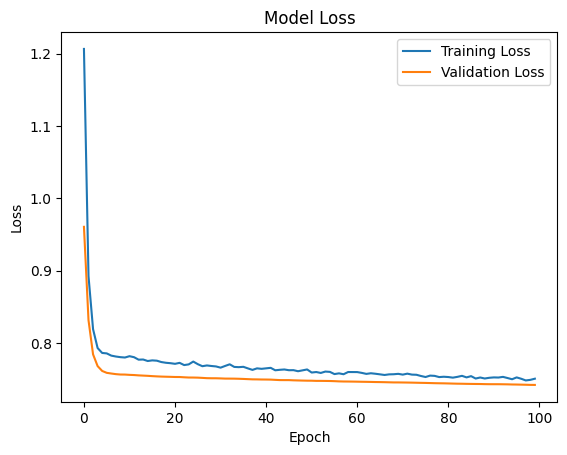

In [ ]:
# Plot loss untuk pelatihan dan validasi
# Plot Loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Saving Model

In [ ]:
model4.save("tourify_model.h5")

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model4, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('tourify_model.tflite')
tflite_model_file.write_bytes(tflite_model)

35284